## Dispersion: prism

This code is the same as 
<a href="https://opticsf2f.github.io/Opticsf2f_CodeBook/PrismRefraction.html">PrismRefraction.ipynb</a>
except that here we are going to use three colours.

We can set the refractive indices for each colour separately and hence explore **dispersion**.

The image we create is iconic. Newton's in his so called *experimentum crucis* studied prism refraction of sunlight adding a second 
prism in the red path to show that you cannot split a primary colour. However, the claim Newton made was not actually 
true as the red light still has a range of wavelengths which diverge after a second prism.

The image is also iconic as a similar image was used as the album cover for Dark Side of the Moon by Pink Floyd in 1973.
A good exercise is to see if you think there is a problem with their back cover?

If you just want to play with the **interactive figure** scroll to the bottom.

The Jupyter Notebook is Disp.ipynb see

https://github.com/opticsf2f/Opticsf2f_CodeBook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.colors as colors
from numpy.fft import fft, ifft, fftshift

import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams["text.latex.preamble"]  = r"\usepackage{amsmath} \usepackage{amssymb} \usepackage[bitstream-charter]{mathdesign}"
mpl.rcParams["text.usetex"] = True

This cell defines a few functions. We shall use Triangle for a prism and GBeam for our input light.

In [2]:
def GBeam(zb,yb,z0,y0,beamsize,angle):
    angle = angle
    za = (zb-z0)*np.cos(angle) + (yb-y0)*np.sin(angle)
    ya = (yb-y0)*np.cos(angle) - (zb-z0)*np.sin(angle)
    zR = np.pi*beamsize**2
    q = za-1.j*zR
    return (-1.j*zR*np.exp(2*np.pi*1.j*(za+ya*ya/(2*q)))/q) 

def Triangle(x,y,x0,y0,size,angle):
    return ((-y-y0 + size/(2*np.cos(angle/2))-np.tan(angle)*(x-x0) > (0)) 
            &  (-y-y0 + size/(2*np.cos(angle/2))+np.tan(angle)*(x-x0) > (0)) 
            & (-y-y0 + size/(2*np.cos(angle/2)) < (size*np.cos(angle/2))))


Next we define a grid in units of the wavelength. $dy$ and $dz$ are the spatial resolution. 
$\lambda/50$ for the values given below.

In [3]:
zmin = 0 # z is the horizontal axis so like x in cartesian system
zmax = 160
ymin = -80   # vertical axis coould be x or y, call it y to agree with standard axes
ymax = 80
dz = 0.1
dy = 0.1
zoom = 1
Z, Y = np.mgrid[zmin/zoom:zmax/zoom:dz/zoom,ymin/zoom:ymax/zoom:dy/zoom]
z_pts, y_pts = np.shape(Z)

This is the $k$-space grid.

In [4]:
kymax=1.0*np.pi/dy 
dky=2*kymax/y_pts
ky=np.arange(-kymax,kymax,dky) # fourier axis scaling
ky2=ky*ky
ky2c=ky2.astype('complex') #Notes on complex types http://www.scipy.org/NegativeSquareRoot
k=2.0*np.pi # k=2pi/lambda with lambda_0=1
k2=k*k
kz=np.sqrt(k2-ky2c)

This is the propagation phase the appear in the hedgehog equation.

In [5]:
ph=1.0j*kz*dz

We define triangle that will become our prism

In [6]:
PSize = 60
PAngle = 60*np.pi/180
PCentre = PSize/(2*np.cos(PAngle/2))
PWidth = PSize*np.sin(PAngle/2)
Prism = Triangle(Z,Y,zmax/2,0,PSize,PAngle)

The next cell does a lot. The first few lines initialise the grid, then we add the prism 
and a gaussian beam in the input plane. The hedgehog equation propagation is on lines 15-18.
Next we add the result, either the electric field or the intensity into the RGB channels, lines 19-23.

The rest of the code is to add rays. 

--- 0.998305082321167 seconds ---


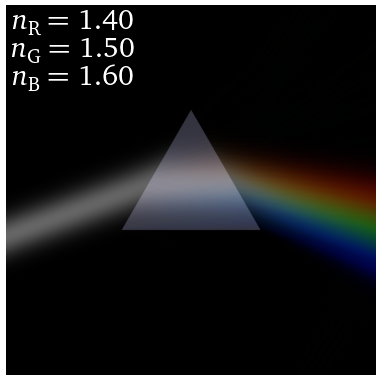

In [7]:
start_time = time.time()

Index = 1.5

R = np.zeros((z_pts,y_pts))
G = np.zeros((z_pts,y_pts))
B = np.zeros((z_pts,y_pts))

Disp = 0.1

NR = np.zeros((z_pts,y_pts))# refractive index
NR += (Index-Disp-1)*Prism # n-1 red 
NG = np.zeros((z_pts,y_pts))# refractive index
NG += (Index-1)*Prism # n-1 green 
NB = np.zeros((z_pts,y_pts))# refractive index
NB += (Index+Disp-1)*Prism # n-1 blue

BeamSize = 8
BAngle = 20*np.pi/180
BeamOffset = -20

E0 = GBeam(Z[0,:],Y[0,:],0,BeamOffset,BeamSize,BAngle)

b = fftshift(fft(E0))
for jj in range (0,z_pts): # propagat
        c = ifft(fftshift(b)) * np.exp(2.0j*np.pi*NR[jj,:]*dz)
        b = fftshift(fft(c)) * np.exp(1.0j*kz*dz)
        R[jj,:] +=  0.2*(abs(c)*abs(c))**0.5
b = fftshift(fft(E0))
for jj in range (0,z_pts): # propagat
        c = ifft(fftshift(b)) * np.exp(2.0j*np.pi*NG[jj,:]*dz)
        b = fftshift(fft(c)) * np.exp(1.0j*kz*dz)
        G[jj,:] +=  0.2*(abs(c)*abs(c))**0.5
b = fftshift(fft(E0))
for jj in range (0,z_pts): # propagat
        c = ifft(fftshift(b)) * np.exp(2.0j*np.pi*NB[jj,:]*dz)
        b = fftshift(fft(c)) * np.exp(1.0j*kz*dz)
        B[jj,:] +=  0.2*(abs(c)*abs(c))**0.5

fig, (ax1) = plt.subplots(1,1,figsize=(8, 8),dpi=60)


R+=0.2*(Index-1)*Prism # add prism to final image
G+=0.2*(Index-1)*Prism
B+=0.25*(Index-1)*Prism

br=2.0 
bg=2.0 
bb=2.0 

R=np.clip(br*R,0.0,1.0)
G=np.clip(bg*G,0.0,1.0)
B=np.clip(bb*B,0.0,1.0)
RGB=np.dstack((np.flipud(R.T), np.flipud(G.T), np.flipud(B.T))) # use transpose to swap image axes, flipud to origin at bottom left

ax1.imshow(RGB)

ax1.text(25,100,r'$n_{\rm R} =$ %.2f' %(Index-Disp),color='white',fontsize = 36)
ax1.text(20,220,r'$n_{\rm G} =$ %.2f' %(Index),color='white',fontsize = 36)
ax1.text(25,340,r'$n_{\rm B} =$ %.2f' %(Index+Disp),color='white',fontsize = 36)


print("--- %s seconds ---" % (time.time() - start_time))

ax1.set_axis_off()


In [8]:
def DispFig(Disp):

    R = np.zeros((z_pts,y_pts))
    G = np.zeros((z_pts,y_pts))
    B = np.zeros((z_pts,y_pts))

    Index = 1.5

    NR = np.zeros((z_pts,y_pts))# refractive index
    NR += (Index-Disp-1)*Prism # n-1 red 
    NG = np.zeros((z_pts,y_pts))# refractive index
    NG += (Index-1)*Prism # n-1 green 
    NB = np.zeros((z_pts,y_pts))# refractive index
    NB += (Index+Disp-1)*Prism # n-1 blue

    BeamSize = 6
    BAngle = 25*np.pi/180
    BeamOffset = -20

    E0 = GBeam(Z[0,:],Y[0,:],0,BeamOffset,BeamSize,BAngle)

    b = fftshift(fft(E0))
    for jj in range (0,z_pts): # propagat
            c = ifft(fftshift(b)) * np.exp(2.0j*np.pi*NR[jj,:]*dz)
            b = fftshift(fft(c)) * np.exp(1.0j*kz*dz)
            R[jj,:] +=  0.2*(abs(c)*abs(c))**0.5
    b = fftshift(fft(E0))
    for jj in range (0,z_pts): # propagat
            c = ifft(fftshift(b)) * np.exp(2.0j*np.pi*NG[jj,:]*dz)
            b = fftshift(fft(c)) * np.exp(1.0j*kz*dz)
            G[jj,:] +=  0.2*(abs(c)*abs(c))**0.5
    b = fftshift(fft(E0))
    for jj in range (0,z_pts): # propagat
            c = ifft(fftshift(b)) * np.exp(2.0j*np.pi*NB[jj,:]*dz)
            b = fftshift(fft(c)) * np.exp(1.0j*kz*dz)
            B[jj,:] +=  0.2*(abs(c)*abs(c))**0.5

    fig, (ax1) = plt.subplots(1,1,figsize=(8, 8),dpi=60)


    R+=0.1*(Index-1)*Prism # add prism to final image
    G+=0.1*(Index-1)*Prism
    B+=0.15*(Index-1)*Prism

    br=2.0 
    bg=2.0 
    bb=2.0 

    R=np.clip(br*R,0.0,1.0)
    G=np.clip(bg*G,0.0,1.0)
    B=np.clip(bb*B,0.0,1.0)
    RGB=np.dstack((np.flipud(R.T), np.flipud(G.T), np.flipud(B.T))) # use transpose to swap image axes, flipud to origin at bottom left

    ax1.imshow(RGB)
    ax1.text(25,80,r'$n_{\rm R} =$ %.2f' %(Index-Disp),color='white',fontsize = 24)
    ax1.text(20,160,r'$n_{\rm G} =$ %.2f' %(Index),color='white',fontsize = 24)
    ax1.text(25,240,r'$n_{\rm B} =$ %.2f' %(Index+Disp),color='white',fontsize = 24)

    ax1.set_axis_off()
    return fig, ""

# optional subplot to check whether we have done axis scaling correctly
#ax2.pcolormesh(Z,Y,B+G)

Finally, we make an interactive figure. We have cranked up the dispersion to unphysical values so that we 
can see the separation of the spectral components. To model white light we would need to add more wavelengths.


In [9]:
from ifigures import *
from ifigures.my_plots import *


PSize = 100
PAngle = 60*np.pi/180
PCentre = PSize/(2*np.cos(PAngle/2))
PWidth = PSize*np.sin(PAngle/2)
Prism = Triangle(Z,Y,zmax/2,0,PSize,PAngle)


start_time = time.time()

figure_example1 = InteractiveFigure(DispFig,
                                    Disp = RangeWidget(0.0, 0.2, 0.02),
)
figure_example1.saveStandaloneHTML("DispInteractive.html")

print("--- %s seconds ---" % (time.time() - start_time))
figure_example1.show()

--- 12.565326690673828 seconds ---
